In [1]:
from google.colab import files
uploaded = files.upload()

Saving orders.csv to orders.csv


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

suspicious_values = ['-', '--', '---', '—', '.', '..', '...', '*', '***', '/', '//', '///', 'x', 'X',
                    'brak', 'aucun', 'kein', 'ไม่มี', 'なし', '없음', 'нет', 'لا يوجد',
                    '', ' ', '  ', '\t', '\n', '\xa0',
                    'na', 'Na', 'NA', 'n/a', 'N/A', 'nA', 'N/a',
'null', 'Null', 'NULL',
'none', 'None', 'NONE',
'missing', 'Missing', 'MISSING',
'not available', 'Not Available', 'NOT AVAILABLE',
'not known', 'Not Known', 'NOT KNOWN',
'not applicable', 'Not Applicable', 'NOT APPLICABLE','UNKNOWN','Unknown','unknown']


df = pd.read_csv('orders.csv',na_values=suspicious_values)

In [39]:
df.shape

(9994, 16)

In [40]:
df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)

In [41]:
#Handling Rows where 'ship_mode' is null
df['ship_mode'] = df['ship_mode'].fillna(df['ship_mode'].mode()[0])

In [42]:
#Converting datatypes ; also to recheck bad data

df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')
df['discount_percent'] = pd.to_numeric(df['discount_percent'], errors='coerce')
df['cost_price'] = pd.to_numeric(df['cost_price'], errors='coerce')
df['list_price'] = pd.to_numeric(df['list_price'], errors='coerce')

df['order_date'] = pd.to_datetime(df['order_date'], format='%Y-%m-%d', errors='coerce')

In [43]:
numerical_cols = ['cost_price','list_price','quantity','discount_percent']

In [44]:
df[numerical_cols].describe()

,cost_price,list_price,quantity,discount_percent
count,9994.000000,9994.000000,9994.000000,9994.000000
mean,201.189714,229.756854,3.789574,3.484090
std,537.743203,623.245839,2.225110,1.114211
min,0.000000,0.000000,1.000000,2.000000
25%,20.000000,20.000000,2.000000,2.000000
50%,50.000000,50.000000,3.000000,3.000000
75%,180.000000,210.000000,5.000000,4.000000
max,18110.000000,22640.000000,14.000000,5.000000


In [45]:
#Dropping Rows where 'cost_price' is zero
df = df[df['cost_price'] != 0]

#Dropping Rows where 'list_price' is zero
df = df[df['list_price'] != 0]

In [46]:
# Function to remove outliers using IQR method per Product Id
def remove_outliers_iqr(df, group_col, target_cols):
    def iqr_filter(group):
        for col in target_cols:
            Q1 = group[col].quantile(0.25)
            Q3 = group[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            group = group[(group[col] >= lower) & (group[col] <= upper)]
        return group

    return df.groupby(group_col, group_keys=False).apply(iqr_filter)


# Apply outlier removal
df_cleaned = remove_outliers_iqr(df, group_col='product_id', target_cols=numerical_cols)

# # Check how many rows were removed
# rows_removed = len(df) - len(df_cleaned)
# rows_removed, df_cleaned.shape


/tmp/ipython-input-46-4277653703.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(iqr_filter)


In [48]:
df_cleaned[numerical_cols].describe()

,cost_price,list_price,quantity,discount_percent
count,8163.000000,8163.000000,8163.000000,8163.000000
mean,194.548573,221.831435,3.627710,3.479603
std,506.572535,583.370497,1.956636,1.107954
min,10.000000,10.000000,1.000000,2.000000
25%,20.000000,20.000000,2.000000,3.000000
50%,50.000000,60.000000,3.000000,3.000000
75%,180.000000,210.000000,5.000000,4.000000
max,18110.000000,22640.000000,14.000000,5.000000


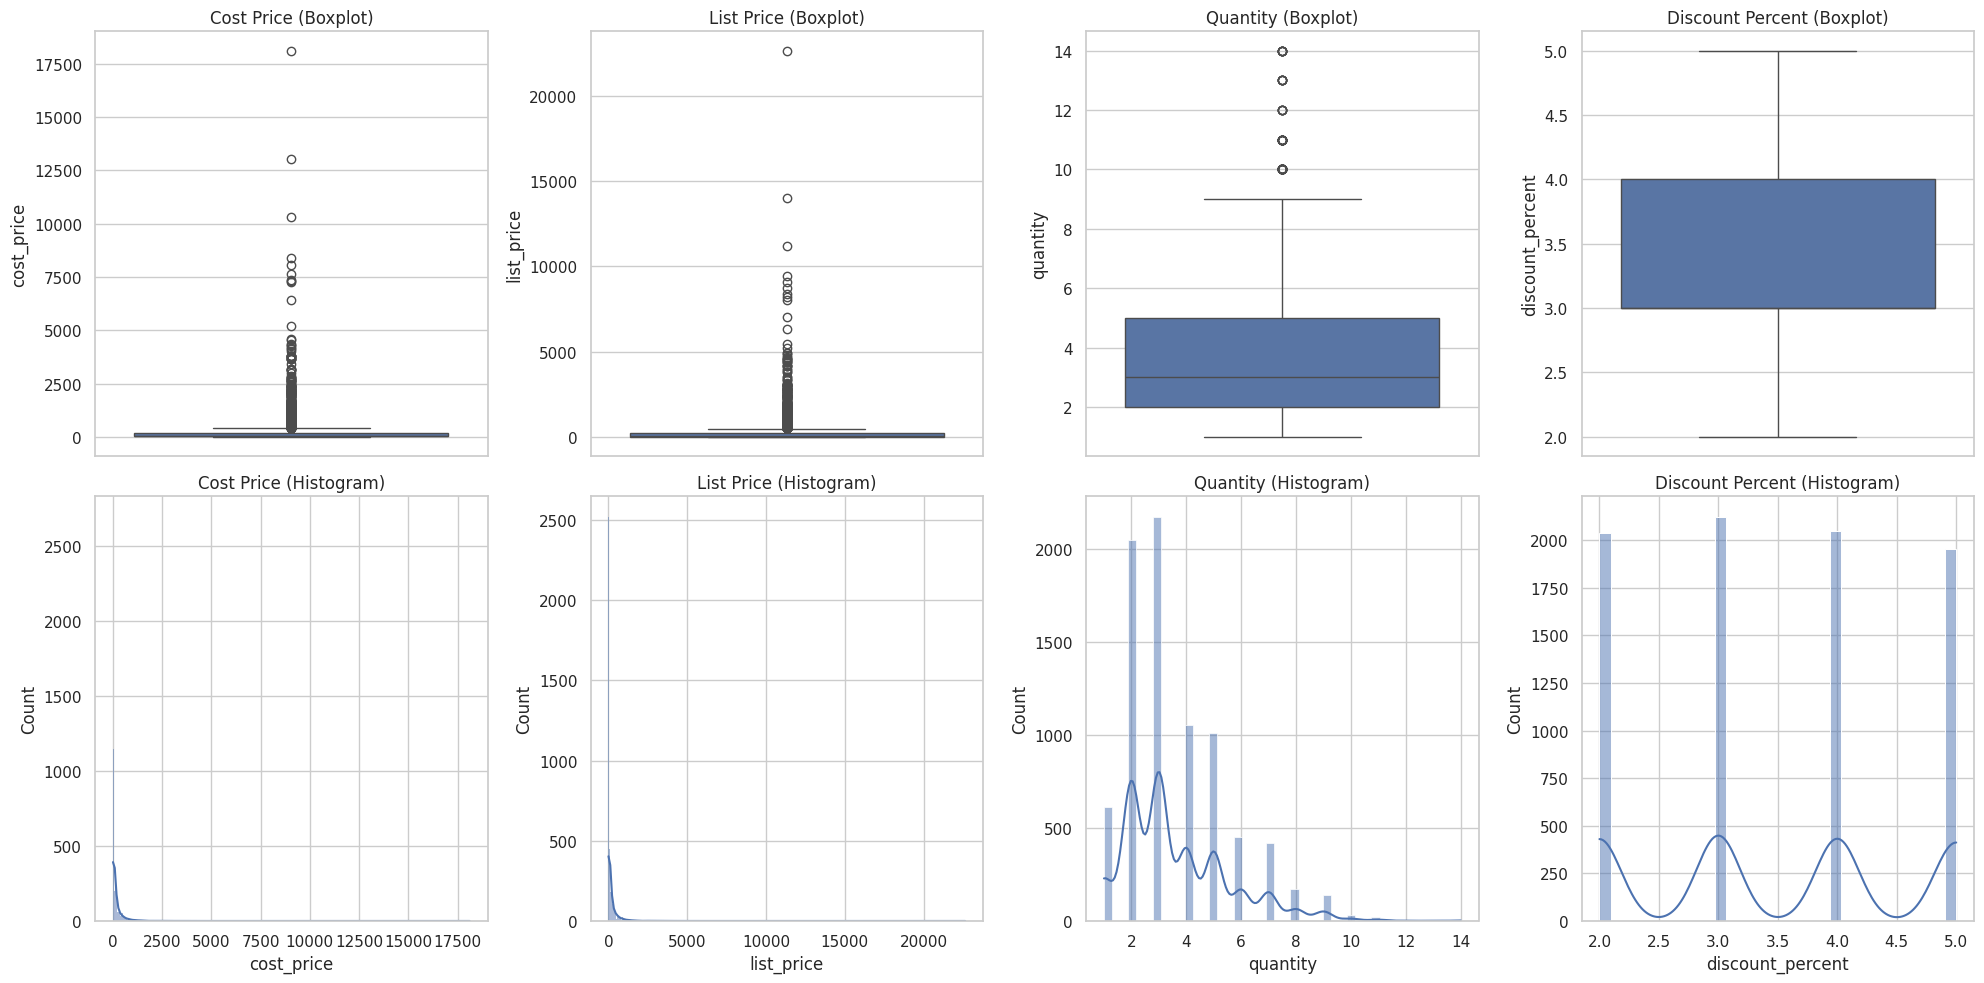

In [49]:

# Setup for consistent style
sns.set(style='whitegrid')
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Boxplots
sns.boxplot(y='cost_price', data=df_cleaned, ax=axes[0, 0]).set(title='Cost Price (Boxplot)')
sns.boxplot(y='list_price', data=df_cleaned, ax=axes[0, 1]).set(title='List Price (Boxplot)')
sns.boxplot(y='quantity', data=df_cleaned, ax=axes[0, 2]).set(title='Quantity (Boxplot)')
sns.boxplot(y='discount_percent', data=df_cleaned, ax=axes[0, 3]).set(title='Discount Percent (Boxplot)')

# Histograms
sns.histplot(df_cleaned['cost_price'], kde=True, ax=axes[1, 0]).set(title='Cost Price (Histogram)')
sns.histplot(df_cleaned['list_price'], kde=True, ax=axes[1, 1]).set(title='List Price (Histogram)')
sns.histplot(df_cleaned['quantity'], kde=True, ax=axes[1, 2]).set(title='Quantity (Histogram)')
sns.histplot(df_cleaned['discount_percent'], kde=True, ax=axes[1, 3]).set(title='Discount Percent (Histogram)')

plt.tight_layout()
plt.show()


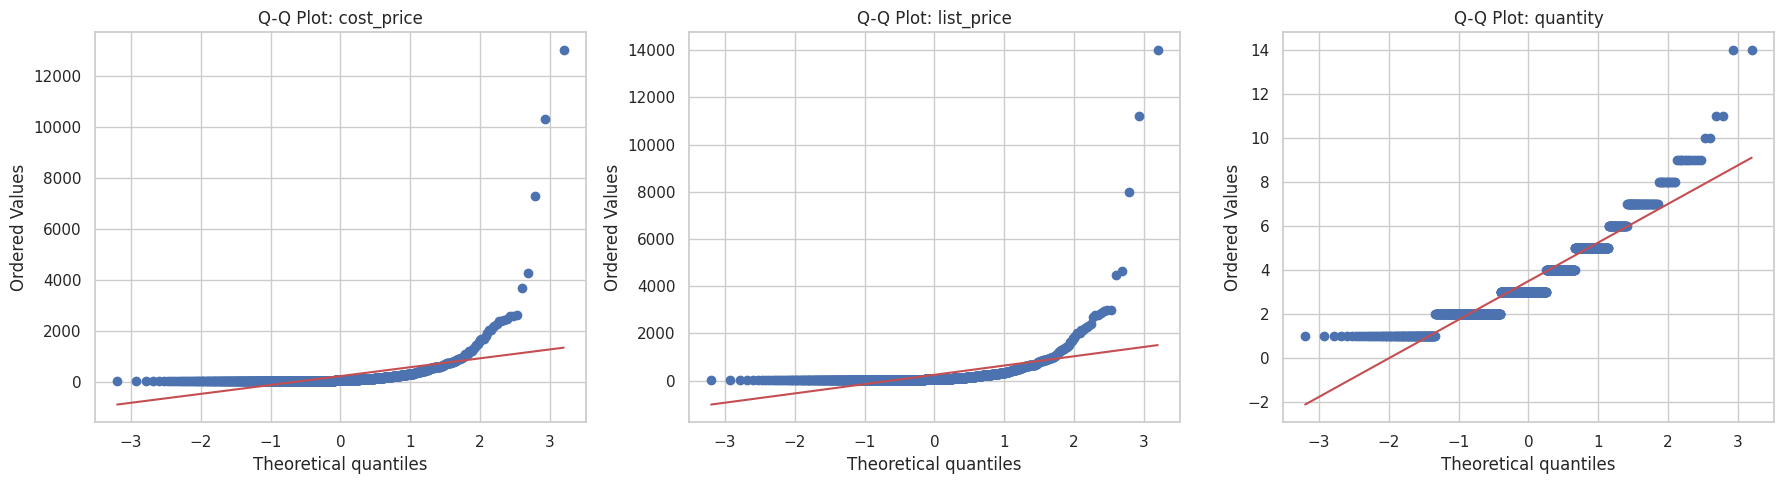

{'cost_price': {'W-statistic': np.float64(0.264), 'p-value': np.float64(0.0)},
 'list_price': {'W-statistic': np.float64(0.2764), 'p-value': np.float64(0.0)},
 'quantity': {'W-statistic': np.float64(0.8922), 'p-value': np.float64(0.0)}}

In [50]:
from scipy.stats import shapiro, probplot

# Sample 1000 rows for stability
sample = df_cleaned[['cost_price', 'list_price', 'quantity']].sample(1000, random_state=1)

# Q-Q plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(sample.columns):
    probplot(sample[col], dist='norm', plot=axes[i])
    axes[i].set_title(f'Q-Q Plot: {col}')

plt.tight_layout()
plt.show()

# Shapiro-Wilk normality test
shapiro_results = {col: shapiro(sample[col]) for col in sample.columns}
shapiro_summary = {col: {'W-statistic': round(res.statistic, 4), 'p-value': round(res.pvalue, 4)}
                   for col, res in shapiro_results.items()}
shapiro_summary


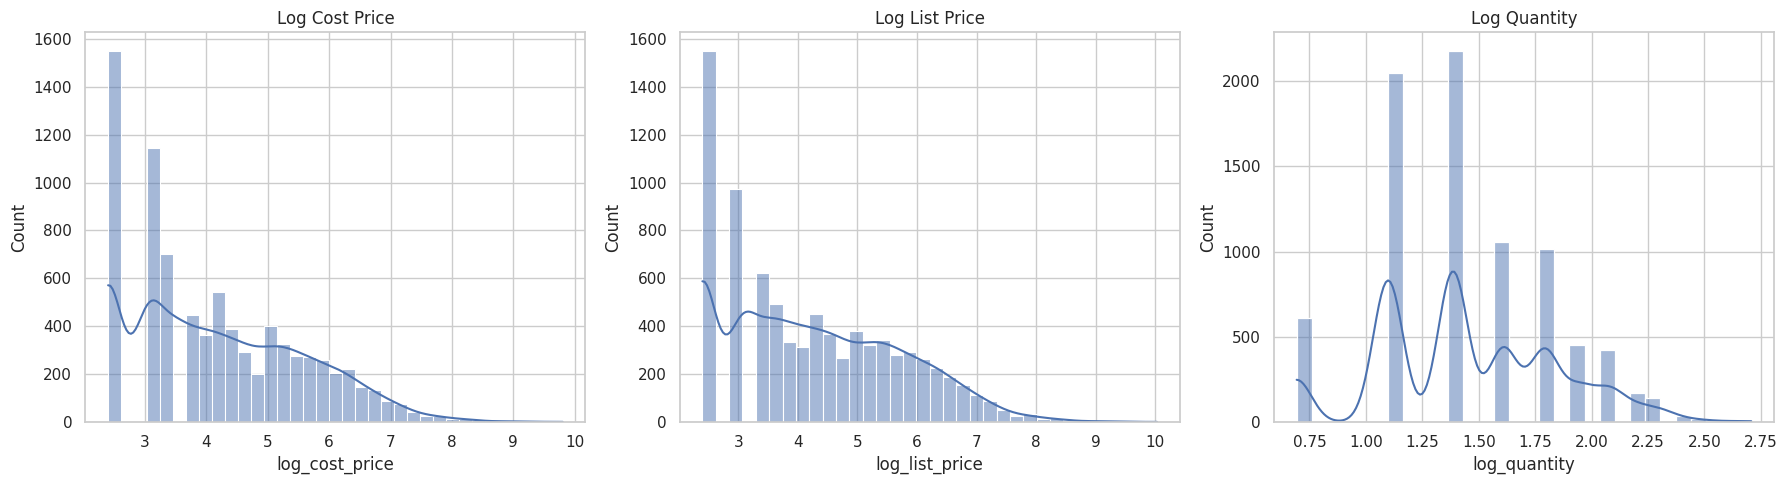

In [51]:
import numpy as np

# Log-transform (add 1 to avoid log(0))
df_cleaned['log_cost_price'] = np.log1p(df_cleaned['cost_price'])
df_cleaned['log_list_price'] = np.log1p(df_cleaned['list_price'])
df_cleaned['log_quantity'] = np.log1p(df_cleaned['quantity'])

# Plot histograms of log-transformed data
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df_cleaned['log_cost_price'], kde=True, ax=axes[0]).set(title='Log Cost Price')
sns.histplot(df_cleaned['log_list_price'], kde=True, ax=axes[1]).set(title='Log List Price')
sns.histplot(df_cleaned['log_quantity'], kde=True, ax=axes[2]).set(title='Log Quantity')
plt.tight_layout()
plt.show()


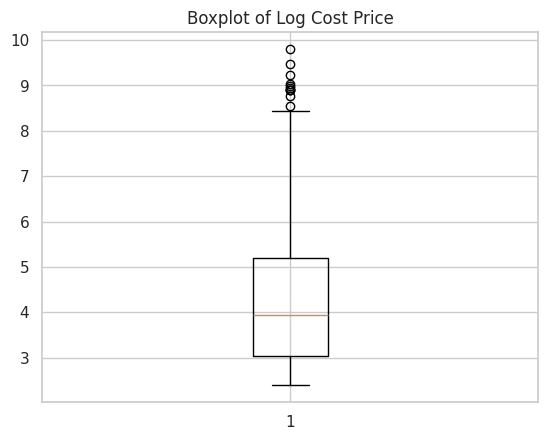

In [52]:
plt.boxplot(df_cleaned['log_cost_price'])
plt.title('Boxplot of Log Cost Price')
plt.show()

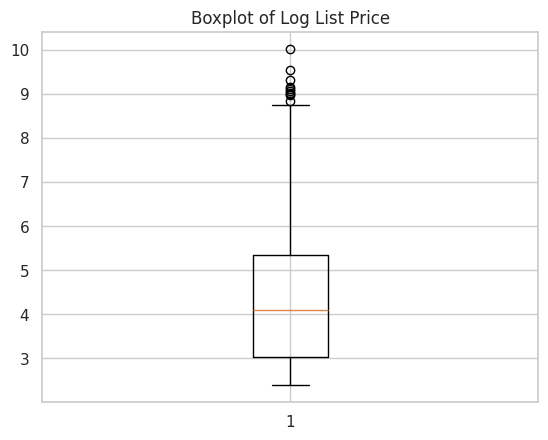

In [53]:
plt.boxplot(df_cleaned['log_list_price'])
plt.title('Boxplot of Log List Price')
plt.show()

In [54]:
#1) Is there a significant difference in average discount between categories?
#Use: Kruskal-Wallis Test (non-parametric ANOVA alternative)

#Null Hypothesis H0: There is no significant difference in average discount between categories.
#Alternative Hypothesis H1: There is a significant difference in average discount between categories.

from scipy.stats import kruskal

# Group discount by category
discount_by_category = [g['discount_percent'] for _, g in df_cleaned.groupby('category')]

# Kruskal-Wallis test
kw_stat, kw_p = kruskal(*discount_by_category)
kw_stat, kw_p


(np.float64(1.2390392010757592), np.float64(0.5382029278974756))

Interpretation:

Since p > 0.05, we fail to reject the null hypothesis.

Conclusion: No significant difference in average discount between product categories.



In [55]:
# 2) Does higher discount cause higher quantity ordered?
# Use: Spearman Correlation (non-parametric)

# H0 : Higher discount doesnt cause higher quntity ordered
# H1 : Higher discount causes higher quntites to be ordered

from scipy.stats import spearmanr

# Spearman correlation between discount and quantity
spearman_corr, spearman_p = spearmanr(df_cleaned['discount_percent'], df_cleaned['quantity'])
spearman_corr, spearman_p


(np.float64(0.011901392069272414), np.float64(0.28230484191529814))

Higher discount doesnt cause higher quntity ordered. No correlation


In [56]:
# Which Month Had Significant Profit Growth? (Use: A/B-style t-test comparing monthly profits)
from scipy.stats import ttest_ind

# Create monthly profit column
df_cleaned['order_date'] = pd.to_datetime(df_cleaned['order_date'])
df_cleaned['year_month'] = df_cleaned['order_date'].dt.to_period('M')
df_cleaned['profit'] = (df_cleaned['list_price'] - df_cleaned['cost_price']) * df_cleaned['quantity']

# Monthly comparison: consecutive months
months = df_cleaned['year_month'].sort_values().unique()
profit_changes = []

for i in range(1, len(months)):
    prev = df_cleaned[df_cleaned['year_month'] == months[i - 1]]['profit']
    curr = df_cleaned[df_cleaned['year_month'] == months[i]]['profit']

    t_stat, p_val = ttest_ind(curr, prev, equal_var=False)

    if p_val < 0.05:
        profit_changes.append({
            'From': str(months[i - 1]),
            'To': str(months[i]),
            'p-value': round(p_val, 4)
        })

profit_changes


[]

No month had a statistically proven jump in profit.


In [57]:
#4) Quantity Ordered Between Segments (Use: Kruskal-Wallis Test)

# H₀: All segments order the same quantity
# H₁: At least one segment differs

# Group quantity by segment
quantity_by_segment = [g['quantity'] for _, g in df_cleaned.groupby('segment')]

# Kruskal-Wallis test
kw_seg_stat, kw_seg_p = kruskal(*quantity_by_segment)
kw_seg_stat, kw_seg_p


(np.float64(2.781182999633213), np.float64(0.24892802019830923))

No significant pattern across customer segments.

In [59]:
# 5) Do Corporate vs Consumer customers get different discounts?
# Use: Mann-Whitney U Test (non-parametric version of t-test)

from scipy.stats import mannwhitneyu

# Filter discount data
corp = df_cleaned[df_cleaned['segment'] == 'Corporate']['discount_percent']
cons = df_cleaned[df_cleaned['segment'] == 'Consumer']['discount_percent']

# Mann-Whitney U Test
u_stat, p_u = mannwhitneyu(corp, cons, alternative='two-sided')
u_stat, p_u


(np.float64(5199797.0), np.float64(0.679496349250559))

No difference in average discount between the two groups (p = 0.68
)

In [60]:
#6)Chi-Square Test for segment vs category

from scipy.stats import chi2_contingency


# Create a contingency table
contingency_table = pd.crosstab(df_cleaned['segment'], df_cleaned['category'])

# Perform the Chi-Square test of independence
chi2_stat, chi2_p, chi2_dof, expected = chi2_contingency(contingency_table)

# Show result
chi2_stat, chi2_p


# Since p > 0.05, we fail to reject the null hypothesis.
#  There is no significant relationship between customer segment and product category.

(np.float64(2.0313138903675405), np.float64(0.7299992475935364))